# 🌿 📈 From Scratch: Polynomial Regression Using OOP

## Hey there!

In this notebook, we’ll be implementing a version of **Polynomial Regression** using **Object-Oriented Programming (OOP)** principles. Before we dive into the implementation, it's important to clarify what we mean by "Polynomial Regression" in this context.

### Is This Really Polynomial Regression?

Technically, what we’re doing here is **Linear Regression** but with a twist: instead of fitting a straight line to the data, we are **transforming the input features** into **polynomial terms** (such as squares, cubes, etc.). This means that the core of our model is still linear, but by modifying the inputs, we can capture non-linear patterns in the data.

So, it's important to note that **this model is still fundamentally linear** in its parameters. The "polynomial" part comes from how we expand the input features by introducing higher-degree terms.

### Why Modify the Inputs?

Polynomial regression works by transforming the input data to higher-order polynomial terms, allowing a linear model to fit more complex, non-linear data. For example, given an input feature `x`, we can create new features like `x²`, `x³`, etc., and include these in the model.

While the model itself remains linear in its parameters (the coefficients), these transformations allow us to fit non-linear data patterns. Essentially, by **modifying the input features**, we can achieve the effect of polynomial regression without actually changing the underlying linear nature of the model.

### Why OOP is Important

Understanding **Object-Oriented Programming (OOP)** is crucial in building more structured, maintainable, and reusable code. In this notebook, we’ll leverage OOP principles to implement Polynomial Regression from scratch. OOP helps us to organize our code into **classes**, making it modular and scalable.

### What You’ll Get Here

We’ll walk through the steps of implementing **Polynomial Regression** with two approaches:

1. **Closed-Form Solution** using the **Normal Equation** (analytical approach).
2. **Gradient Descent** for iterative optimization.

We’ll also incorporate **regularization techniques** (Ridge and ElasticNet) to handle cases where the model may overfit the data.

### Reminder: Start with Linear Regression

Before diving into this notebook, I highly recommend checking out the Linear Regression version of this tutorial, which lays the foundation for understanding how regression models work and introduces OOP concepts in a simpler context. You can find it here:

[From Scratch: Linear Regression Using OOP](https://www.kaggle.com/code/matinmahmoudi/from-scratch-linear-regression-using-oop)

---



In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class PolynomialRegression:
    """
    Polynomial Regression implemented from scratch with closed-form solution (Normal Equation) and gradient descent.
    """
    
    def __init__(self, degree=1, method='gradient_descent', learning_rate=0.01, epochs=1000, tolerance=1e-6, verbose=0, penalty='none', alpha=0.1, l1_ratio=0.5):
        self.degree = degree  # Degree of the polynomial
        self.method = method  # Optimization method
        self.learning_rate = learning_rate  # Learning rate for gradient descent
        self.epochs = epochs  # Number of iterations for gradient descent
        self.tolerance = tolerance  # Tolerance for early stopping
        self.verbose = verbose  # Verbosity level
        self.penalty = penalty  # Regularization type ('none', 'l1', 'l2')
        self.alpha = alpha  # Regularization strength
        self.l1_ratio = l1_ratio  # Elastic net ratio
        self.coef_ = None  # Model coefficients (weights)
        self.loss_history_ = []  # History of loss values
        self.r2_score_ = None  # R² score

    def _polynomial_features(self, X):
        """
        Generate polynomial features for input data X up to the given degree.
        """
        n_samples, n_features = X.shape
        X_poly = np.ones((n_samples, 1))  # Start with the bias (intercept term)
        
        # Add polynomial terms up to the specified degree
        for d in range(1, self.degree + 1):
            for i in range(n_features):
                X_poly = np.hstack((X_poly, X[:, i:i+1]**d))
        
        return X_poly

    def fit(self, X, y):
        """
        Train the polynomial regression model.
        """
        # Transform input data into polynomial features
        X_poly = self._polynomial_features(X)
        
        if self.method == 'closed_form':
            self._fit_closed_form(X_poly, y)  # Closed-form solution (Normal Equation)
        elif self.method == 'gradient_descent':
            self._fit_gradient_descent(X_poly, y)  # Gradient descent optimization
        else:
            raise ValueError("Invalid method. Choose 'closed_form' or 'gradient_descent'.")
                
    def _fit_closed_form(self, X, y):
        """
        Fit the model using the closed-form solution (Normal Equation):
        θ = (XᵀX)^(-1)Xᵀy
        """
        if self.penalty == 'none':
            self.coef_ = np.linalg.pinv(X.T @ X) @ X.T @ y  # Without regularization
        elif self.penalty == 'l2':
            I = np.eye(X.shape[1])  # Identity matrix
            I[0, 0] = 0  # Don't regularize the bias term
            self.coef_ = np.linalg.pinv(X.T @ X + self.alpha * I) @ X.T @ y  # Ridge Regression
        else:
            raise ValueError("Closed-form only supports 'none' and 'l2' penalties.")

    def _fit_gradient_descent(self, X, y):
        """
        Fit the model using gradient descent.
        """
        n_samples, n_features = X.shape
        self.coef_ = np.random.randn(n_features, 1)  # Initialize weights
        
        for epoch in range(self.epochs):
            predictions = self._predict_internal(X)  # Predictions: Xθ
            mse = self._calculate_mse(y, predictions)  # Mean Squared Error
            penalty = self._calculate_penalty()  # Regularization penalty (if any)
            total_loss = mse + penalty  # Total loss
            self.loss_history_.append(total_loss)  # Track loss
            
            gradients = self._compute_gradients(X, y, predictions)  # Compute gradients
            self._update_weights(gradients)  # Update weights
            
            # Early stopping if the loss change is smaller than tolerance
            if epoch > 0 and abs(self.loss_history_[-2] - self.loss_history_[-1]) < self.tolerance:
                if self.verbose:
                    print(f"Early stopping at epoch {epoch}")
                break
            
            if self.verbose and epoch % 100 == 0:
                print(f'Epoch {epoch}: Loss = {total_loss:.4f}')
                
        self.plot_learning_curve()

    def _predict_internal(self, X):
        """
        Internal prediction method.
        """
        return X @ self.coef_  # Xθ

    def _compute_gradients(self, X, y, predictions):
        """
        Compute the gradients for gradient descent.
        """
        n_samples = X.shape[0]
        error = predictions - y
        gradients = (2 / n_samples) * X.T @ error
        
        # Add regularization gradients
        if self.penalty == 'l2' or self.penalty == 'elasticnet':
            gradients += 2 * self.alpha * self.coef_
        if self.penalty == 'l1' or self.penalty == 'elasticnet':
            gradients += self.alpha * self.l1_ratio * np.sign(self.coef_)
        
        return gradients

    def _update_weights(self, gradients):
        """
        Update the weights based on the gradients.
        """
        self.coef_ -= self.learning_rate * gradients  # Gradient descent step
    
    def _calculate_mse(self, y, predictions):
        """
        Calculate the Mean Squared Error (MSE).
        """
        return np.mean((y - predictions) ** 2)
    
    def _calculate_penalty(self):
        """
        Calculate the regularization penalty.
        """
        if self.penalty == 'l2':
            return self.alpha * np.sum(self.coef_ ** 2)
        elif self.penalty == 'l1':
            return self.alpha * np.sum(np.abs(self.coef_))
        elif self.penalty == 'elasticnet':
            l1_penalty = self.alpha * self.l1_ratio * np.sum(np.abs(self.coef_))
            l2_penalty = self.alpha * (1 - self.l1_ratio) * np.sum(self.coef_ ** 2)
            return l1_penalty + l2_penalty
        else:
            return 0

    def predict(self, X):
        """
        Make predictions using the trained model.
        """
        X_poly = self._polynomial_features(X)  # Transform input features into polynomial features
        return self._predict_internal(X_poly)
    
    def score(self, X, y):
        """
        Calculate the R² score to evaluate the model.
        """
        X_poly = self._polynomial_features(X)  # Transform input features
        predictions = self._predict_internal(X_poly)  # Model predictions
        ss_res = np.sum((y - predictions) ** 2)  # Residual sum of squares
        ss_tot = np.sum((y - y.mean()) ** 2)  # Total sum of squares
        return 1 - (ss_res / ss_tot)  # R² score
    
    def plot_learning_curve(self):
        """
        Plot the learning curve if gradient descent is used.
        """
        if self.loss_history_:
            plt.plot(self.loss_history_)
            plt.title("Learning Curve")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.grid(True)
            plt.show()

    def __repr__(self):
        return f'PolynomialRegression(degree={self.degree}, method={self.method}, learning_rate={self.learning_rate}, epochs={self.epochs}, penalty={self.penalty})'


Epoch 0: Loss = 1444.7221
Epoch 100: Loss = 421.0044
Epoch 200: Loss = 403.7509
Epoch 300: Loss = 403.4530
Epoch 400: Loss = 403.4472
Early stopping at epoch 456


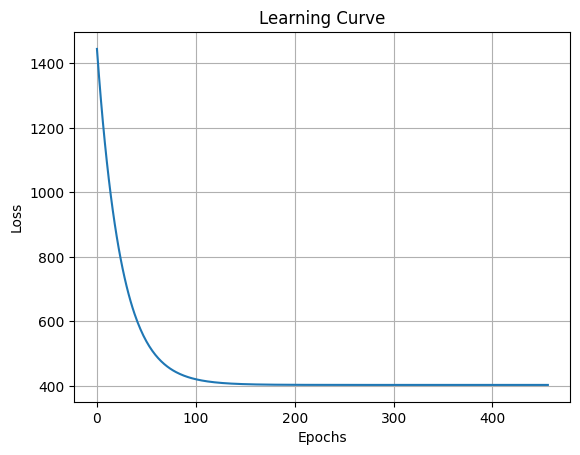

R² Score: 0.7203


In [3]:
# Generate a random regression problem using sklearn's make_regression
X, y = make_regression(n_samples=10000, n_features=1, noise=20, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape y to make it a column vector
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Initialize the custom PolynomialRegression model
degree = 2  # Set the polynomial degree
model = PolynomialRegression(degree=degree, method='gradient_descent', learning_rate=0.01, epochs=1000, verbose=1, penalty='none')

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model performance using R² score
r2_score = model.score(X_test, y_test)
print(f"R² Score: {r2_score:.4f}")


## Wrapping Up

Thank you for following along with this implementation of **Polynomial Regression** using **OOP** from scratch! I hope you found it helpful in understanding both the algorithm and the importance of **Object-Oriented Programming** in structuring machine learning code.

If you have any questions or if something wasn't clear, feel free to drop a comment! I would also love to hear your feedback, so don’t hesitate to share any thoughts or suggestions you might have.

Happy coding and learning! 😊
